# Nama Anggota :
# - Azahra Alayda Faris (50422306)
# - Vindiar Johan Diputra (51422609)

# Segmentasi Buah Menggunakan Deep Learning dengan Dataset FruitSeg30


# 🎯 Tujuan Project

Melakukan **Segmentasi Buah Multi-Kelas** menggunakan dataset FruitSeg30 dengan ±30 jenis buah. Tujuan utama adalah melatih model *semantic segmentation* yang mampu mengenali dan memisahkan setiap buah berdasarkan mask anotasinya.

---

# 🧭 Rencana Awal Project

## 1. Exploratory Data Analysis (EDA)

* Mengekstrak dan memvalidasi struktur dataset.
* Mengidentifikasi seluruh kelas buah beserta jumlah gambar & mask.
* Menampilkan contoh gambar & mask setiap kategori.
* Visualisasi histogram:

  * RGB Histogram (distribusi warna objek)
  * Grayscale Histogram (pencahayaan & kontras)
  * Mask Histogram (validasi mask biner)
* Memeriksa kualitas dataset: ukuran, format, mask rusak, dan konsistensi.

---

## 2. Preprocessing Dataset

* Resize seluruh gambar ke ukuran standar (misal 256×256 atau 512×512).
* Normalisasi nilai piksel sesuai model deep learning.
* Mengonversi mask menjadi label kelas (0–N).
* Melakukan data augmentation (flip, rotation, brightness, crop).
* Membagi dataset:

  * 70% train
  * 20% validation
  * 10% test

---

## 3. Pemilihan dan Desain Model

Menentukan arsitektur segmentasi terbaik, antara lain:

* **U-Net / UNet++**
* **DeepLabV3+**
* **SegFormer**

Menentukan backbone (ResNet, EfficientNet, MiT) dan loss function:

* Cross Entropy
* Dice Loss
* Focal Loss

---

## 4. Training Model

* Menentukan hyperparameter (batch size, epoch, lr).
* Melakukan training dengan monitoring:

  * Training vs validation loss
  * IoU per kelas
  * mIoU keseluruhan
* Early stopping untuk mencegah overfitting.

---

## 5. Evaluasi Model

* Menghitung:

  * IoU per kelas buah
  * Pixel Accuracy
  * Mean IoU (mIoU)
* Membuat visualisasi:

  * Input → Ground Truth Mask → Predicted Mask
* Analisis error:

  * kelas yang sulit diprediksi
  * mask yang tidak akurat
  * gambar yang buruk kualitasnya

---

## 6. Inferensi & Deployment

* Membuat fungsi/pipeline untuk memprediksi gambar baru.
* Menyediakan output overlay antara gambar dan mask prediksi.
* Opsional:

  * Deploy sebagai API (FastAPI, Flask)
  * Deploy sebagai web app (Gradio, Streamlit)
  * Konversi model ke ONNX atau TensorRT

---

## 7. Dokumentasi

* Semua tahap (EDA → preprocessing → training → evaluasi → deployment) dicatat dalam notebook.
* Menyimpan grafik, hasil prediksi, serta analisis dataset.

---

# 🎉 Output Akhir Project

Pada akhir project, hasil yang dihasilkan adalah:

### 1. **Model Segmentasi Buah Siap Pakai**

File model terlatih (mis. `model.pth` atau `model.h5`) yang mampu melakukan segmentasi multi-kelas untuk 30 jenis buah.

### 2. **mIoU dan IoU per Kelas**

Metrik akurasi utama model:

* IoU tiap buah (apel, pisang, jeruk, dll.)
* Mean IoU keseluruhan
* Grafik perkembangan training/validation IoU & loss

### 3. **Visualisasi Hasil Segmentasi**

Notebook menghasilkan:

* Gambar asli
* Mask ground truth
* Mask prediksi
* Overlay prediksi di atas gambar

### 4. **Dataset Terproses**

Output preprocessing meliputi:

* Gambar yang sudah dinormalisasi
* Mask yang sudah label-encoded
* Dataset split train/val/test
* Dataset augmented

### 5. **EDa Visualisations**

Termasuk:

* RGB histogram (warna dominan buah)
* Grayscale histogram (pencahayaan & kontras)
* Mask histogram (validasi kualitas mask)
* Contoh visualisasi tiap buah

### 6. **Pipeline Inferensi**

Script untuk memprediksi mask dari gambar baru:

* Input: foto buah
* Output: klasifikasi mask + visual overlay

### 7. **Dokumentasi Lengkap**

Notebook final yang berisi:

* EDA
* Preprocessing
* Training
* Evaluasi
* Kesimpulan
* Rekomendasi perbaikan


---
---
---



In [2]:
# --- Impor Library ---
import os
import zipfile
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


## EDA


## --- Ekstrak Dataset ---

In [3]:
import os
import zipfile

zip_path = "FruitSeg30_.zip"
extract_to = "dataset"

def extract_zip(zip_path, extract_to):
    """Ekstrak dataset FruitSeg30 ke folder yang ditentukan"""
    if os.path.exists(extract_to):
        print(f"📂 Folder '{extract_to}' sudah ada — ekstraksi dilewati.")
        return extract_to

    print(f"🔍 Mengekstrak ZIP: {zip_path}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_to)

    print(f"✅ Ekstraksi selesai!")
    return extract_to

extract_zip(zip_path, extract_to)
# Base path extract
extract_base_path = "dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30"



📂 Folder 'dataset' sudah ada — ekstraksi dilewati.


In [4]:
def find_all_fruit_datasets(base_path):
    """Mencari folder buah yang memiliki Images dan Mask."""
    fruit_datasets = []

    if not os.path.exists(base_path):
        print(f"❌ Path dasar tidak ditemukan: {base_path}")
        return []

    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            fruit_path = os.path.join(root, dir_name)
            images_path = os.path.join(fruit_path, 'Images')
            masks_path = os.path.join(fruit_path, 'Mask')

            if os.path.exists(images_path) and os.path.exists(masks_path):
                image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

                if image_files and mask_files:
                    fruit_datasets.append({
                        'fruit_name': dir_name,
                        'fruit_path': fruit_path,
                        'images_path': images_path,
                        'masks_path': masks_path,
                        'image_count': len(image_files),
                        'mask_count': len(mask_files)
                    })

    return fruit_datasets

datasets = find_all_fruit_datasets(extract_base_path)
datasets

[{'fruit_name': 'Apple_Gala',
  'fruit_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Gala',
  'images_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Gala\\Images',
  'masks_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Gala\\Mask',
  'image_count': 65,
  'mask_count': 65},
 {'fruit_name': 'Apple_Golden Delicious',
  'fruit_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Golden Delicious',
  'images_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Golden Delicious\\Images',
  'masks_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Golden Delicious\\Mask',
  'image_count': 57,
  'mask_count': 57},
 {'fruit_name': 'Avocado',
  'fruit_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Avocado',
  'images_path': 'dataset/FruitSeg30_Segmentati

In [30]:
def get_dataset_stats(fruit_dataset):
    """
    Mengembalikan statistik dataset (jumlah file, ukuran rata-rata, format).
    """
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    stats = {
        'Fruit': fruit_dataset['fruit_name'],
        'Images': len(image_files),
        'Masks': len(mask_files),
        'Avg. Size (WxH)': 'N/A',
        'Formats': 'N/A'
    }

    if image_files:
        sample_files = random.sample(image_files, min(5, len(image_files)))
        widths, heights, fmts = [], [], []

        for img_name in sample_files:
            with Image.open(os.path.join(images_path, img_name)) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                fmts.append(img.format)

        stats['Avg. Size (WxH)'] = f"{np.mean(widths):.0f} x {np.mean(heights):.0f}"
        stats['Formats'] = ", ".join(sorted(set(fmts)))

    return stats

stats = [get_dataset_stats(ds) for ds in datasets]
df_stats = pd.DataFrame(stats)
df_stats


Fruit  Images  Masks Avg. Size (WxH) Formats
0               Apple_Gala      65     65       512 x 512    JPEG
1   Apple_Golden Delicious      57     57       512 x 512    JPEG
2                  Avocado      72     72       512 x 512    JPEG
3                   Banana      82     82       512 x 512    JPEG
4                    Berry      62     62       512 x 512    JPEG
5            Burmese Grape      78     78       512 x 512    JPEG
6                Carambola     100    100       512 x 512    JPEG
7                Date Palm     147    147       512 x 512    JPEG
8                   Dragon      96     96       512 x 512    JPEG
9           Elephant Apple      81     81       512 x 512    JPEG
10                   Grape      82     82       512 x 512    JPEG
11           Green Coconut      37     37       512 x 512    JPEG
12                   Guava      55     55       512 x 512    JPEG
13                Hog Plum      91     91       512 x 512    JPEG
14                    Kiwi      61     61       512 x 512    JPEG
15                   Lichi      48     48       512 x 512    JPEG
16                   Malta      50     50       512 x 512    JPEG
17      Mango Golden Queen      16     16       512 x 512    JPEG
18          Mango_Alphonso      45     45       512 x 512    JPEG
19          Mango_Amrapali      67     67       512 x 512    JPEG
20              Mango_Bari      57     57       512 x 512    JPEG
21          Mango_Himsagar      85     85       512 x 512    JPEG
22                   Olive      51     51       512 x 512    JPEG
23                  Orange      83     83       512 x 512    JPEG
24                    Palm      59     59       512 x 512    JPEG
25               Persimmon      33     33       512 x 512    JPEG
26               Pineapple      65     65       512 x 512    JPEG
27             Pomegranate      61     61       512 x 512    JPEG
28              Watermelon      42     42       512 x 512    JPEG
29              White Pear      41     41       512 x 512    JPEG

## Menampilkan gambar dan mask yang cocok

In [6]:
def visualize_single_sample(fruit_dataset):
    fruit_name = fruit_dataset['fruit_name']
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    valid_pairs = []

    for img_file in image_files:
        base = os.path.splitext(img_file)[0]
        possible_masks = [
            f"{base}_mask.png", f"{base}_mask.jpg",
            f"{base}.png", f"{base}.jpg",
        ]
        for mask_name in possible_masks:
            if mask_name in mask_files:
                valid_pairs.append((img_file, mask_name))
                break

    if not valid_pairs:
        print("❌ Tidak ada pasangan gambar-mask.")
        return

    img_file, mask_file = random.choice(valid_pairs)
    img = Image.open(os.path.join(images_path, img_file))
    mask = Image.open(os.path.join(masks_path, mask_file))

    # --- Visualisasi ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # TITLE UTAMA
    fig.suptitle(f"Sample Visualisation – {fruit_name}", fontsize=16, fontweight="bold")

    # Gambar
    ax[0].imshow(img)
    ax[0].set_title(f"{fruit_name} – Image\n{img_file}")
    ax[0].axis("off")

    # Mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f"{fruit_name} – Mask\n{mask_file}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()



## Menampilkan sample gambar+mask untuk setiap buah dalam datasets.

📊 Menampilkan sample untuk 30 buah...

=== 🍎 Apple_Gala ===


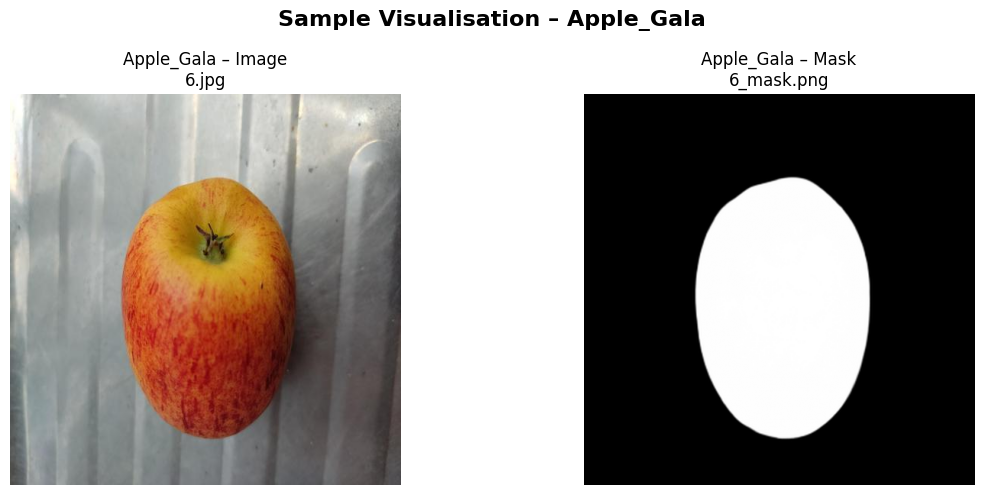



=== 🍎 Apple_Golden Delicious ===


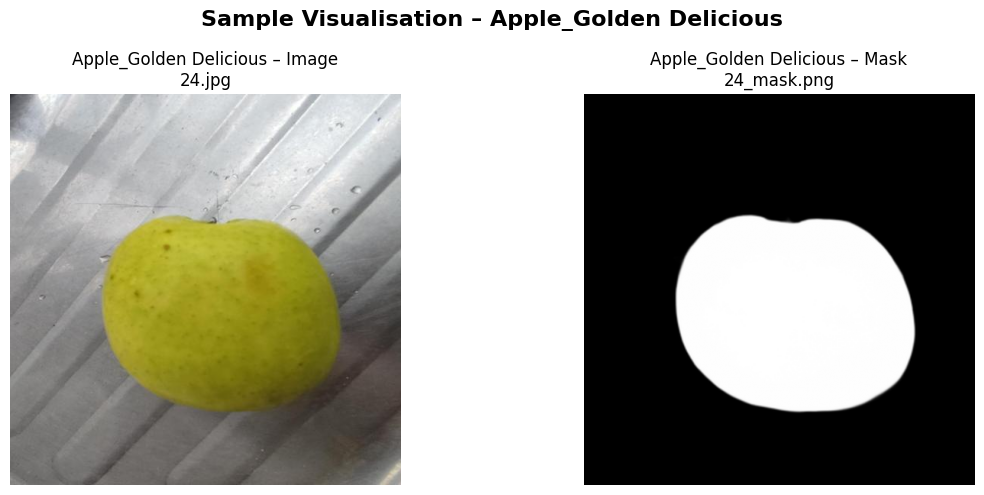



=== 🍎 Avocado ===


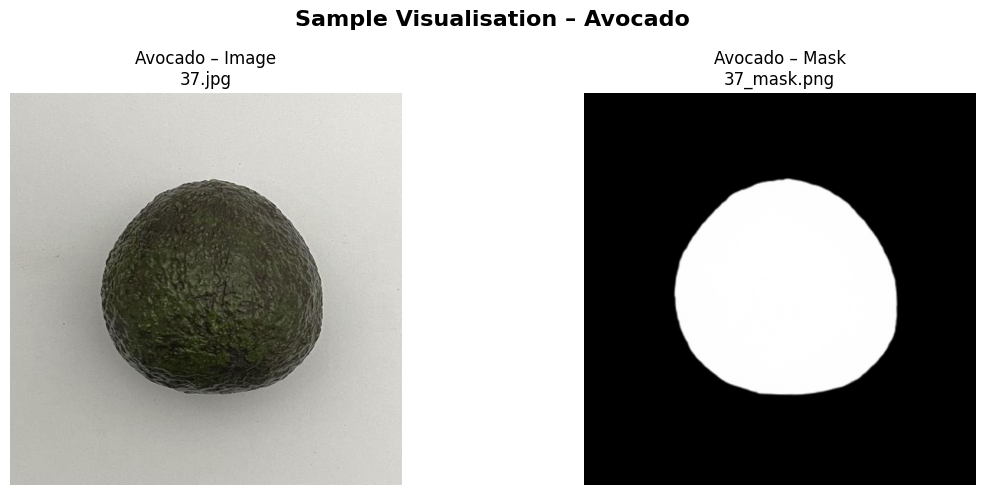



=== 🍎 Banana ===


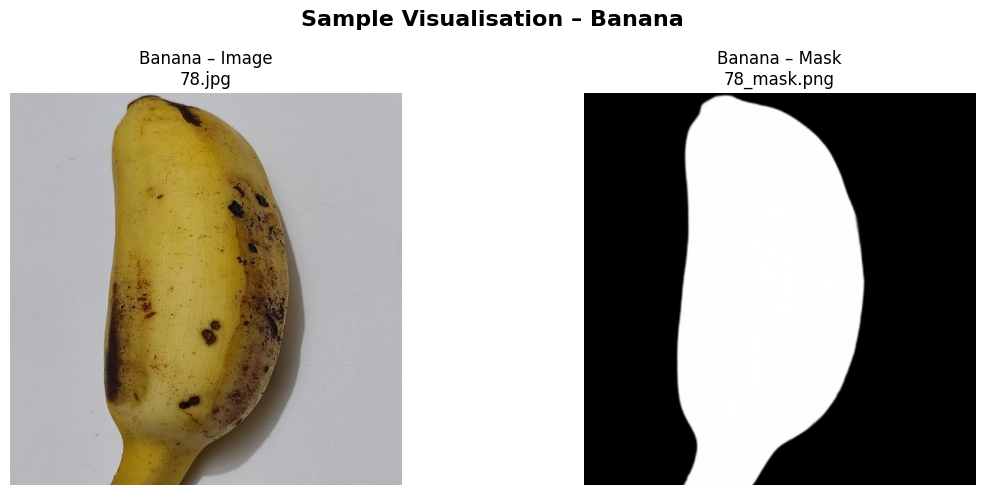



=== 🍎 Berry ===


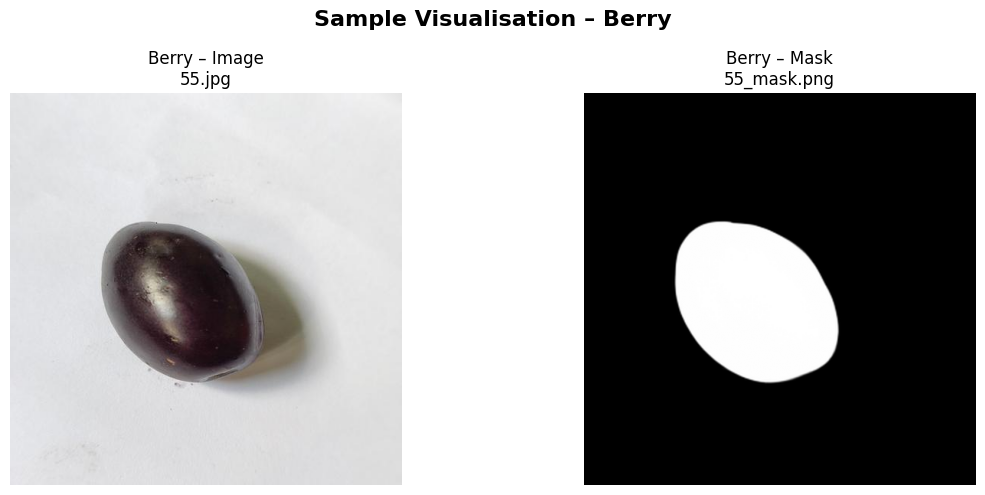



=== 🍎 Burmese Grape ===


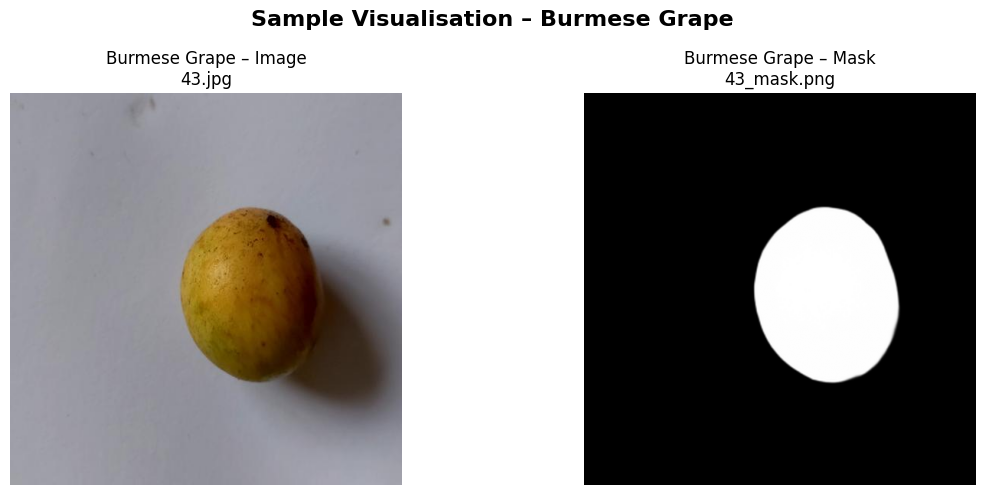



=== 🍎 Carambola ===


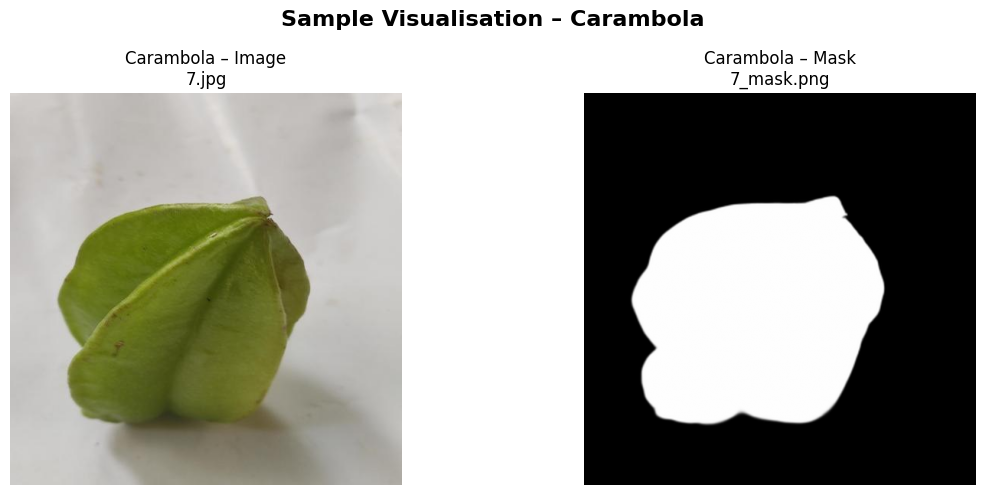



=== 🍎 Date Palm ===


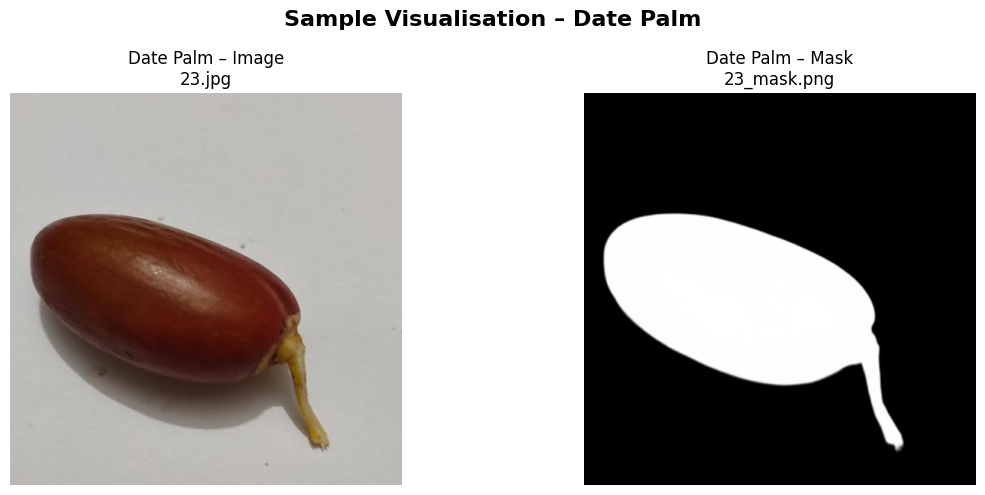



=== 🍎 Dragon ===


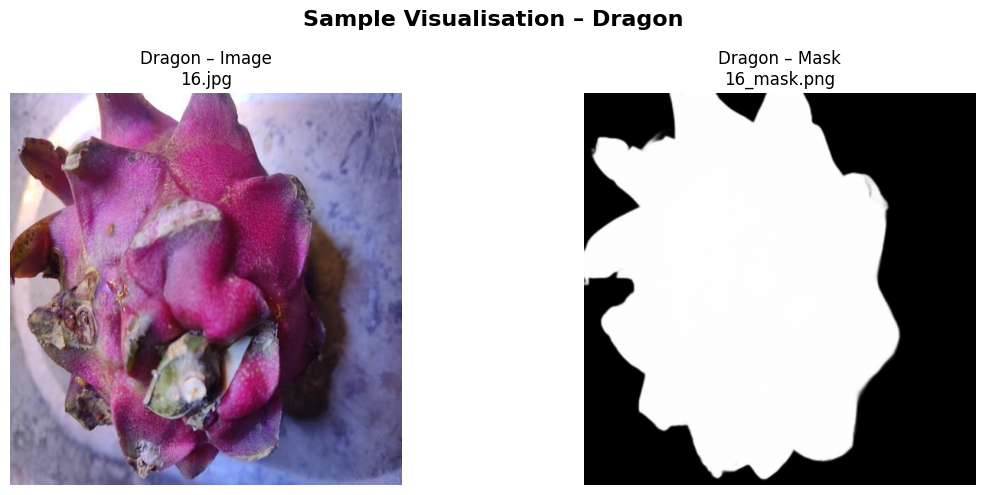



=== 🍎 Elephant Apple ===


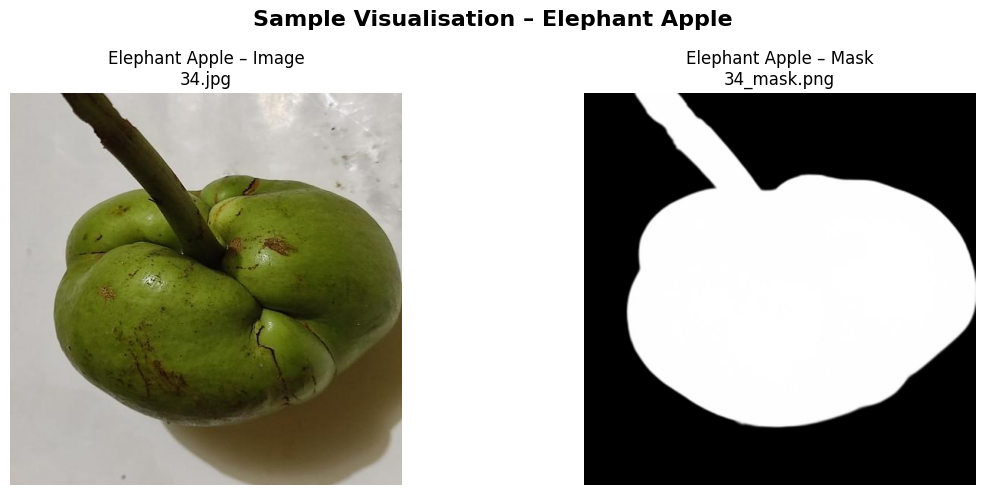



=== 🍎 Grape ===


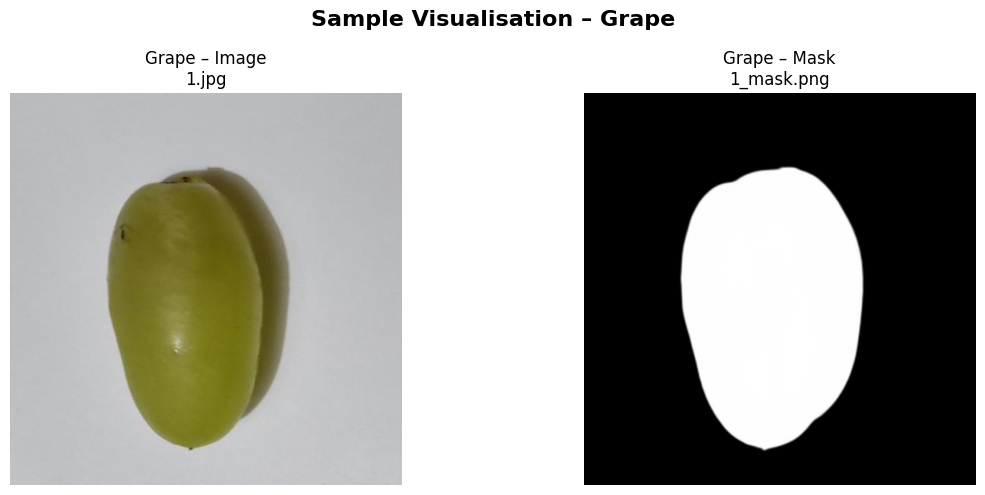



=== 🍎 Green Coconut ===


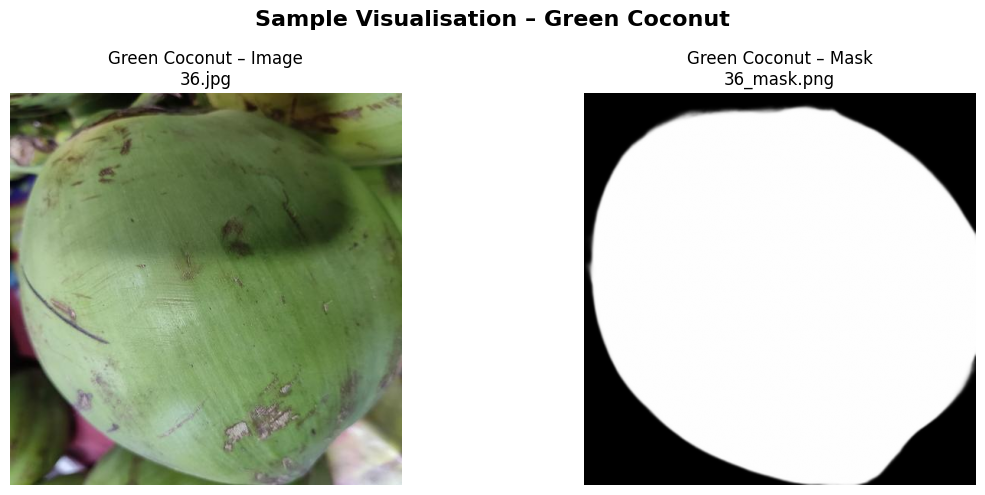



=== 🍎 Guava ===


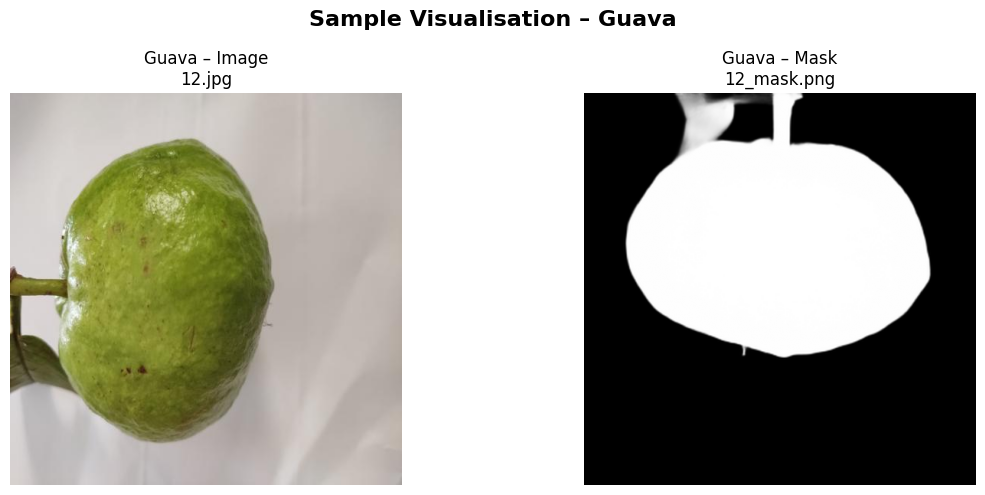



=== 🍎 Hog Plum ===


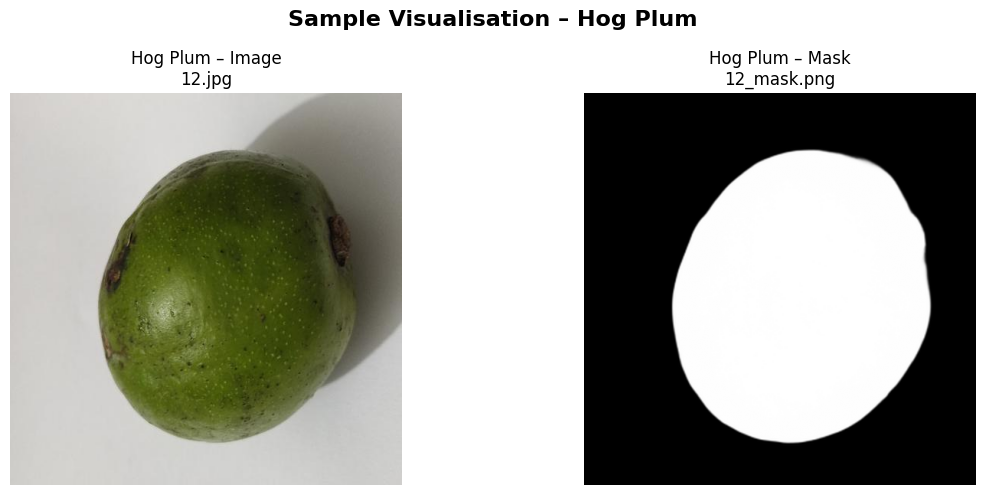



=== 🍎 Kiwi ===


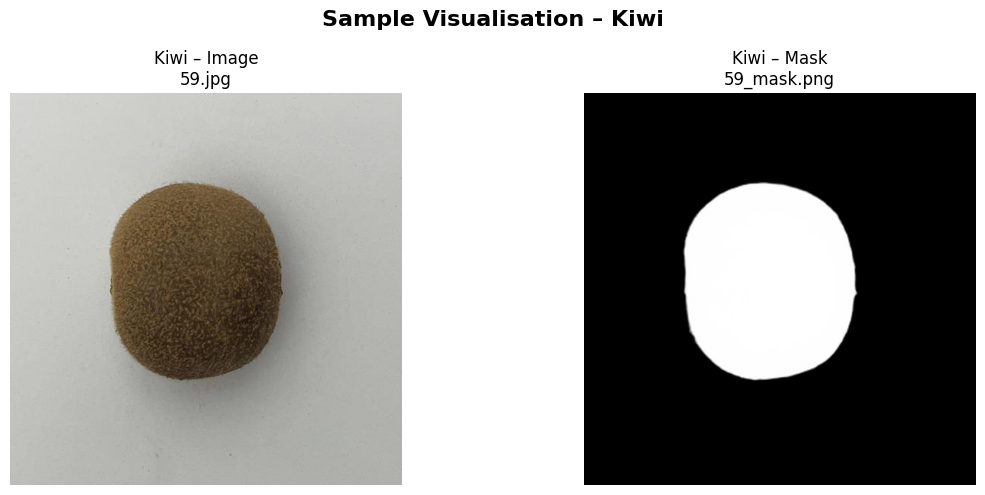



=== 🍎 Lichi ===


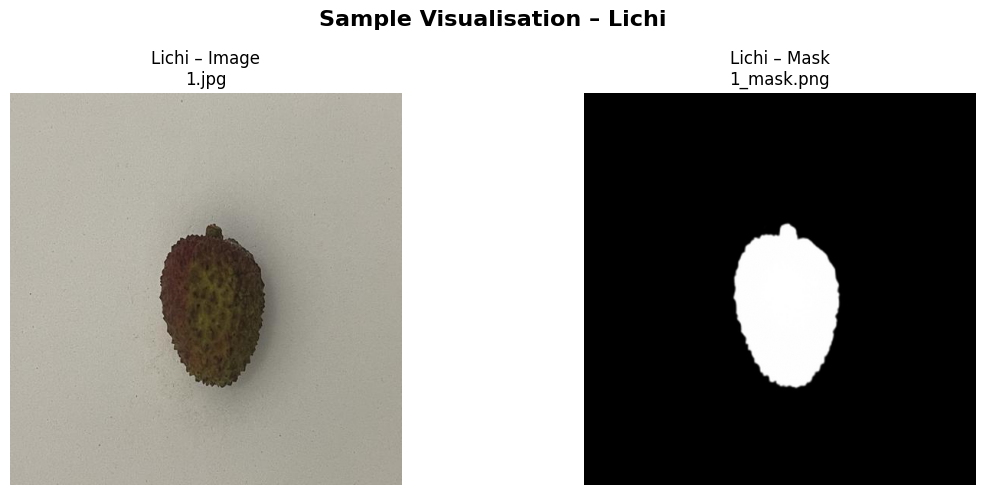



=== 🍎 Malta ===


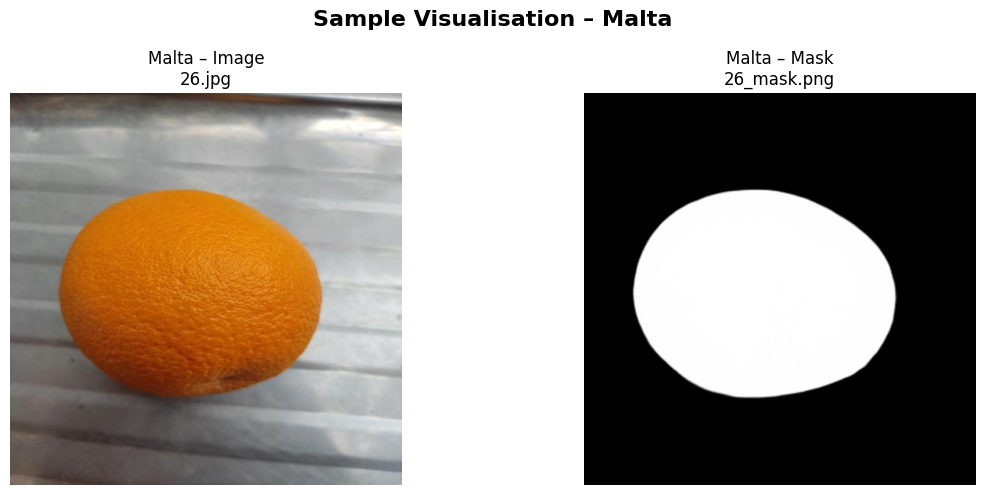



=== 🍎 Mango Golden Queen ===


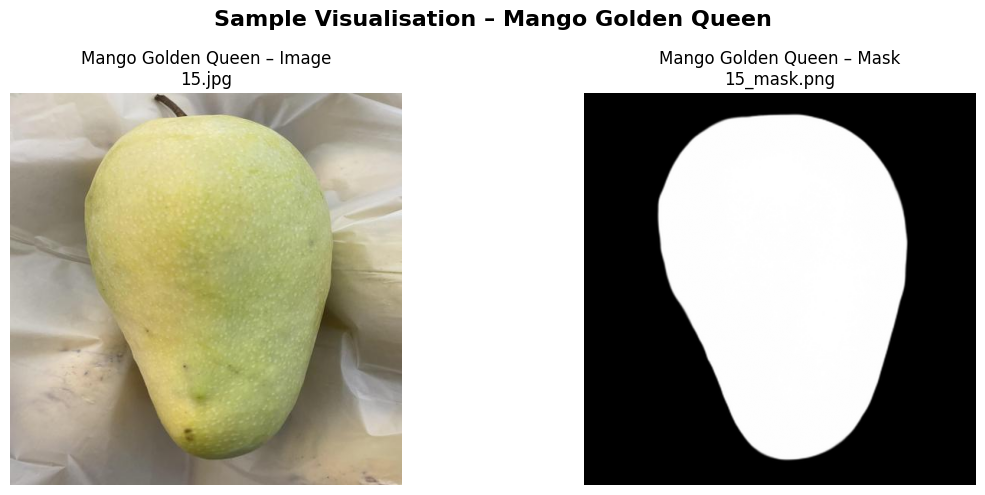



=== 🍎 Mango_Alphonso ===


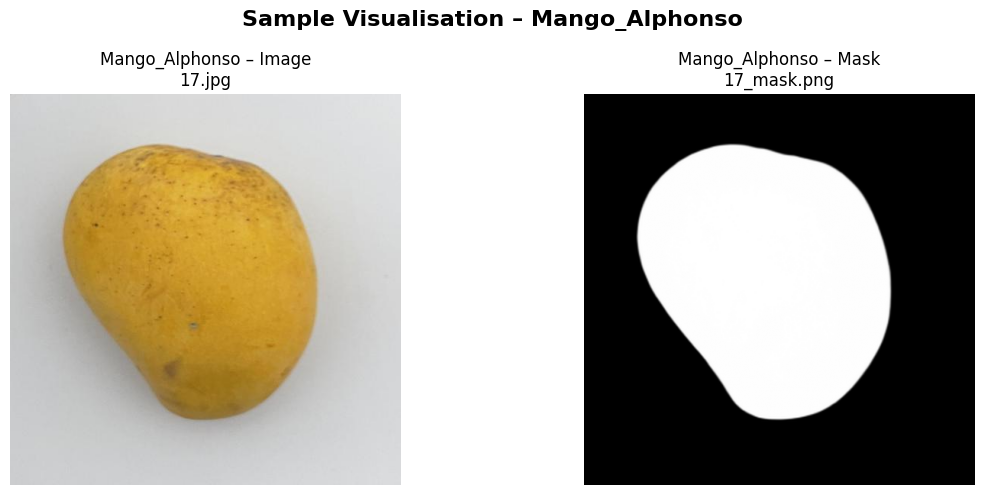



=== 🍎 Mango_Amrapali ===


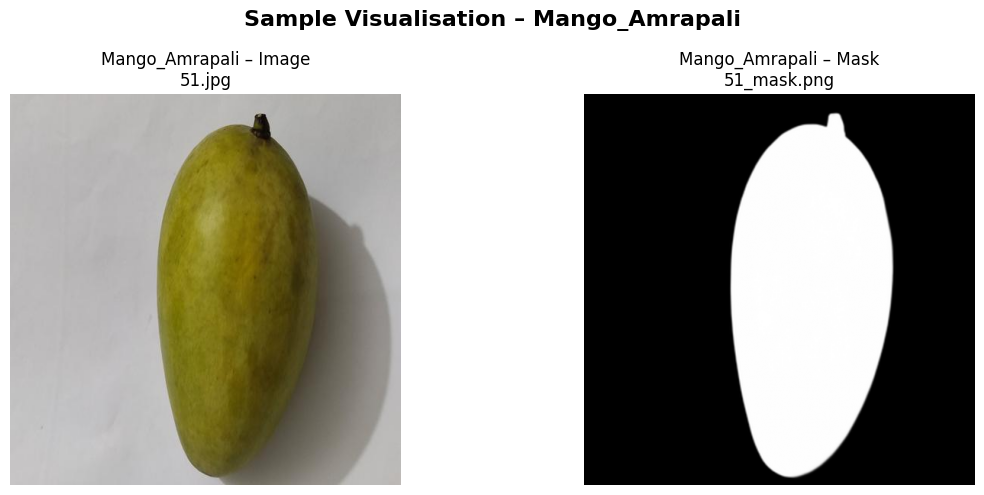



=== 🍎 Mango_Bari ===


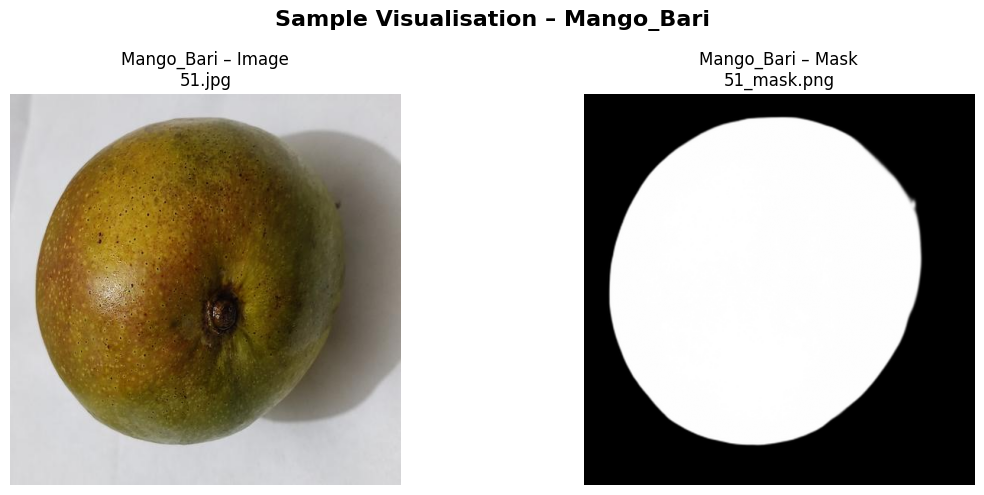



=== 🍎 Mango_Himsagar ===


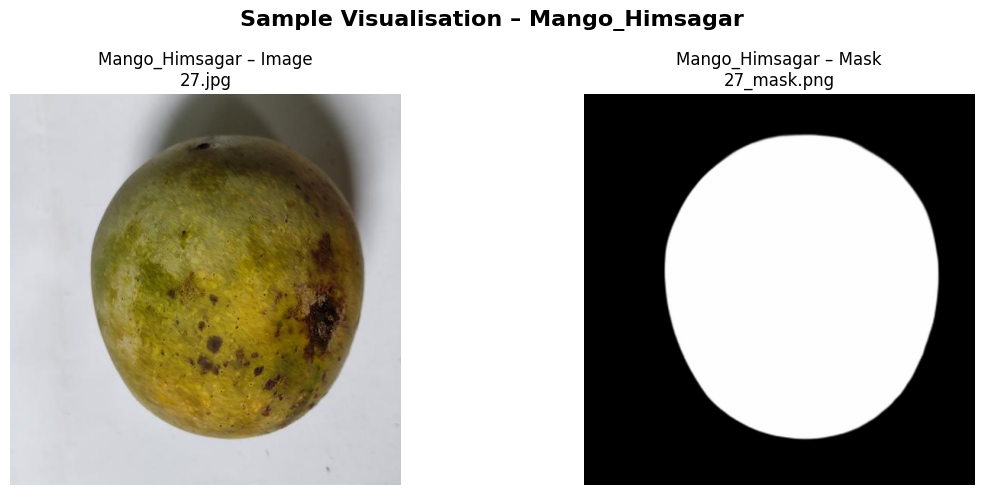



=== 🍎 Olive ===


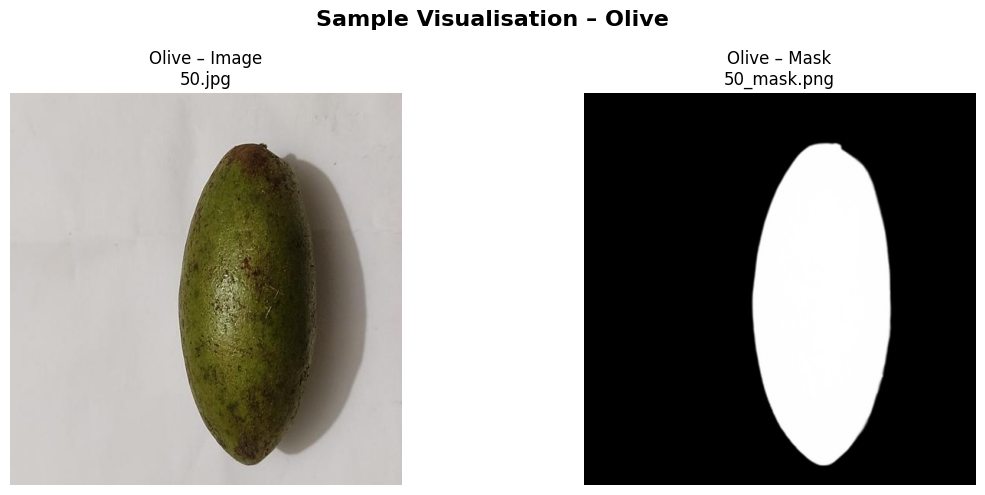



=== 🍎 Orange ===


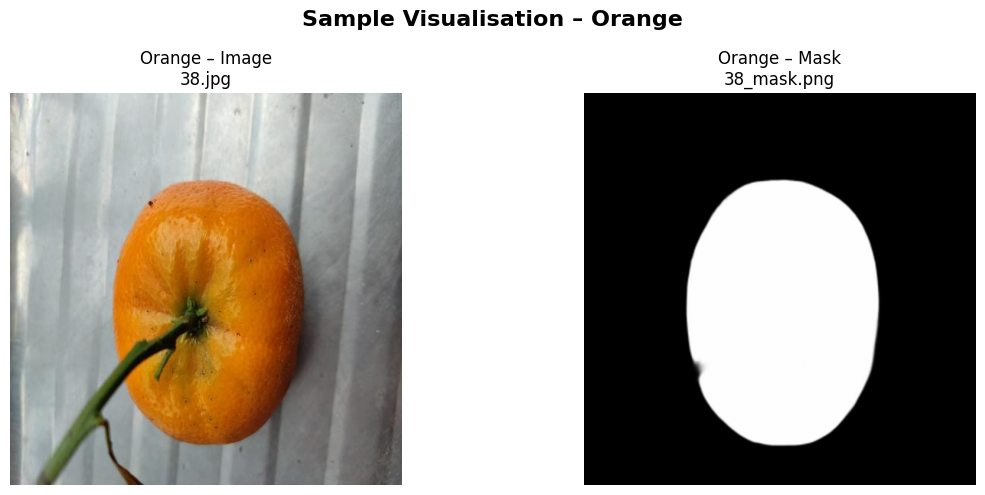



=== 🍎 Palm ===


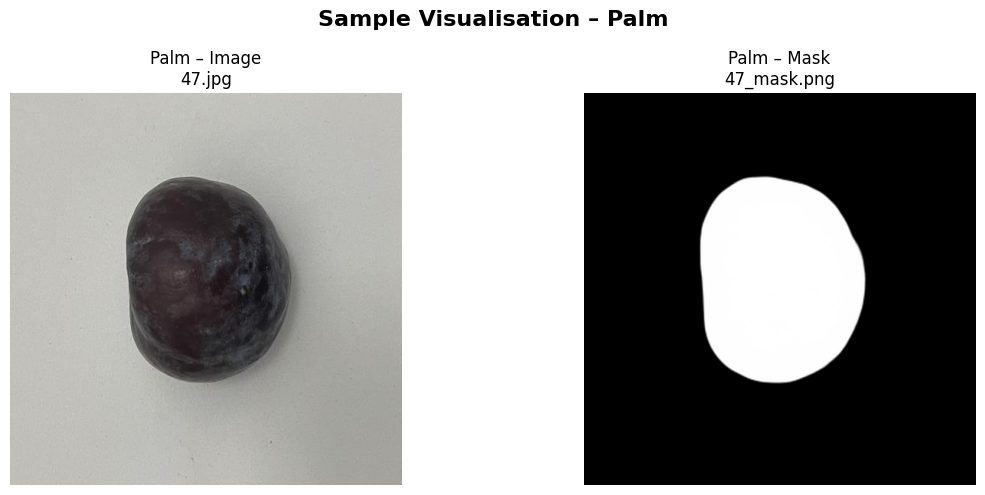



=== 🍎 Persimmon ===


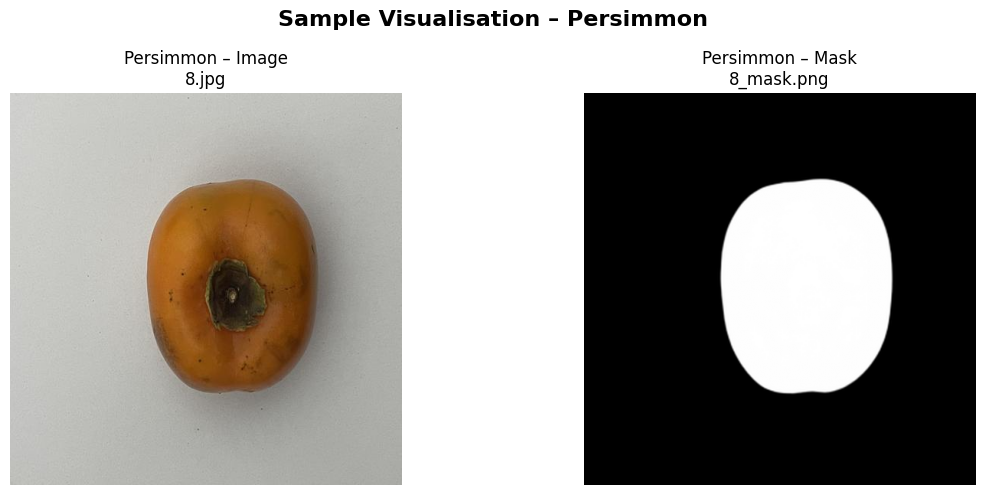



=== 🍎 Pineapple ===


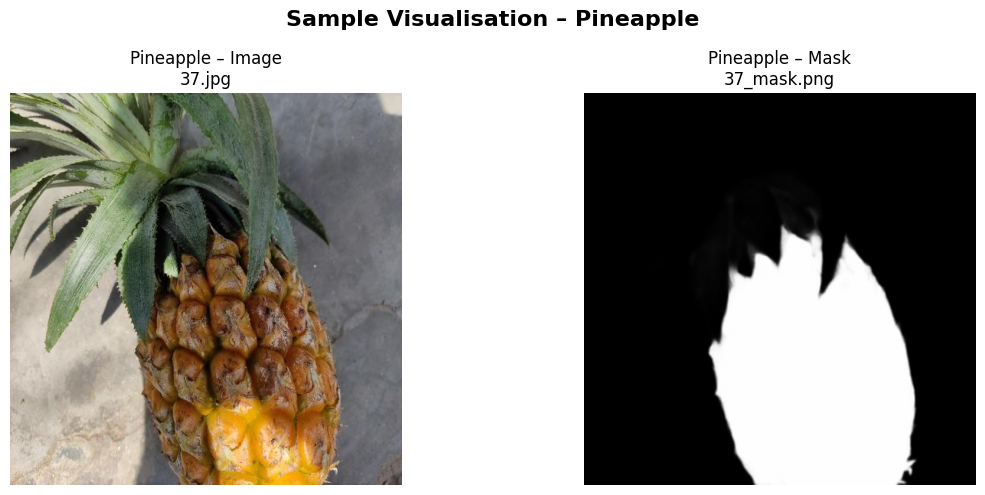



=== 🍎 Pomegranate ===


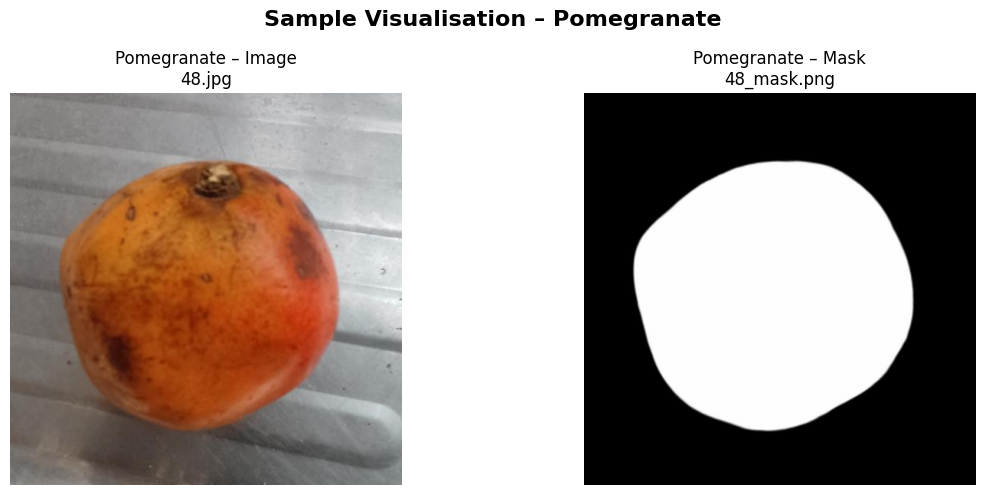



=== 🍎 Watermelon ===


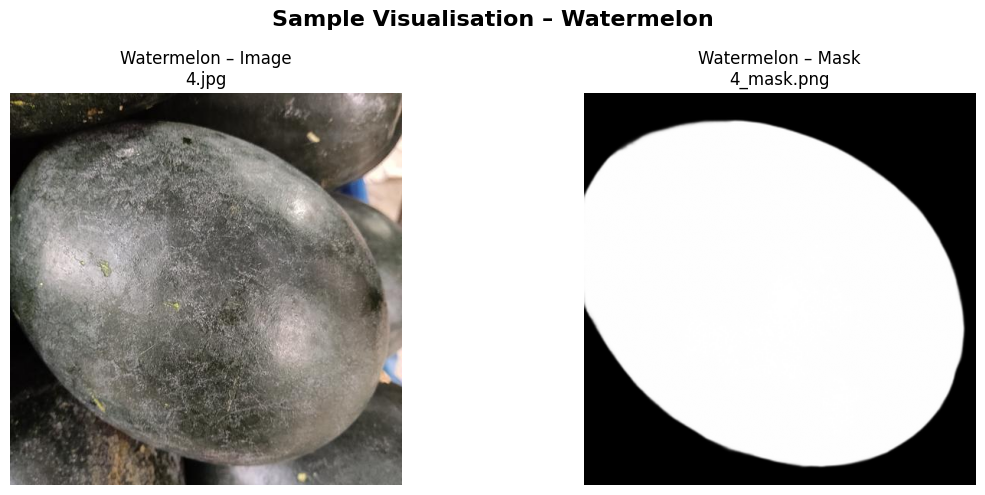



=== 🍎 White Pear ===


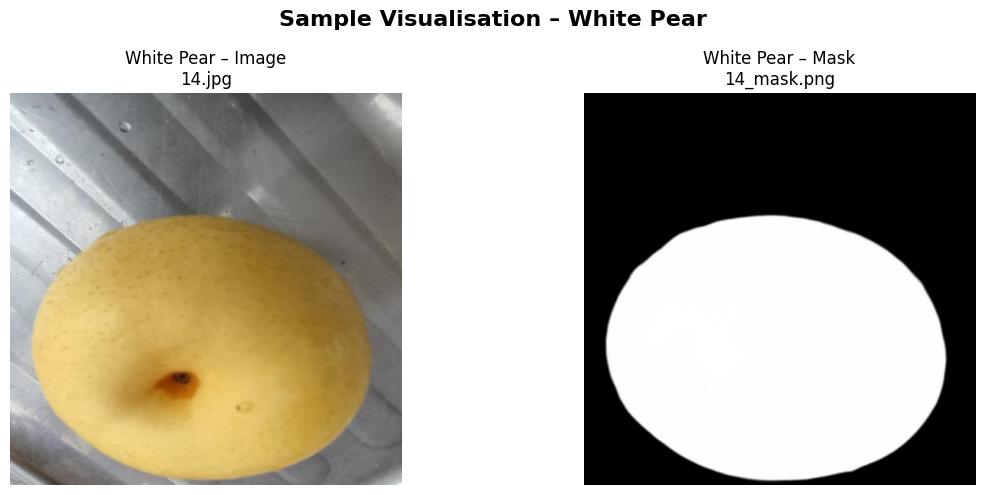

In [7]:
def visualize_all_fruits(datasets):
    if not datasets:
        print("❌ Tidak ada dataset buah.")
        return

    print(f"📊 Menampilkan sample untuk {len(datasets)} buah...\n")

    for fruit_dataset in datasets:
        fruit_name = fruit_dataset['fruit_name']
        print(f"=== 🍎 {fruit_name} ===")
        visualize_single_sample(fruit_dataset)
        print("\n")
        
visualize_all_fruits(datasets)



## Histogram channel (R,G,B)

Histogram digunakan dalam Exploratory Data Analysis (EDA) karena memberikan gambaran statistik mengenai distribusi intensitas warna pada gambar. Pada dataset segmentasi buah, histogram memiliki beberapa peran penting:

---

### **1. Memeriksa Kualitas Pencahayaan Gambar**

Histogram membantu melihat apakah gambar:

* terlalu gelap (*underexposed*),
* terlalu terang (*overexposed*),
* memiliki kontras kurang baik.

Hal ini penting agar model segmentasi tidak terganggu oleh variasi pencahayaan.

---

### **2. Mengidentifikasi Karakteristik Warna pada Buah**

Buah memiliki warna dominan, seperti:

* apel → merah / hijau
* pisang → kuning
* jeruk → oranye

Histogram RGB membantu memastikan bahwa warna objek terekam dengan baik dan tidak tertutup oleh warna background.

---

### **3. Mendeteksi Gambar Outlier atau Bermasalah**

Histogram memudahkan mendeteksi gambar yang:

* terlalu gelap/terang,
* memiliki saturasi tidak wajar,
* penuh noise,
* background mendominasi warna dan mengganggu objek.

Gambar semacam ini perlu dicek atau dibersihkan untuk meningkatkan kualitas dataset.

---

### **4. Validasi Kualitas Mask Segmentasi**

Pada mask biner, histogram seharusnya hanya menunjukkan dua nilai intensitas:

* **0 (background)**
* **255 (buah/objek)**

Jika histogram mask memperlihatkan banyak nilai selain itu, berarti terdapat:

* mask tidak bersih,
* ada area transparan atau semi-transparan,
* atau mask hasil segmentasi otomatis yang belum benar.

---

### **5. Membantu Menentukan Strategi Augmentasi**

Dari histogram, dapat ditentukan apakah dataset memerlukan:

* penyesuaian kecerahan (brightness),
* peningkatan kontras,
* color jitter,
* normalisasi warna tertentu.



In [8]:
def plot_rgb_histogram(image):
    img = np.array(image)

    colors = ('red', 'green', 'blue')
    plt.figure(figsize=(6, 4))

    for i, col in enumerate(colors):
        plt.hist(img[:,:,i].ravel(), bins=256, alpha=0.6, label=col, color=col)

    plt.title("RGB Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [9]:
def plot_grayscale_histogram(image):
    gray = np.array(image.convert("L"))

    plt.figure(figsize=(6, 4))
    plt.hist(gray.ravel(), bins=256, alpha=0.8)
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()


In [10]:
def plot_mask_histogram(mask):
    mask_arr = np.array(mask)

    plt.figure(figsize=(6, 4))
    plt.hist(mask_arr.ravel(), bins=50)
    plt.title("Mask Histogram (Check Label Value)")
    plt.xlabel("Mask Pixel Value")
    plt.ylabel("Count")
    plt.show()


📸 Menampilkan sample...


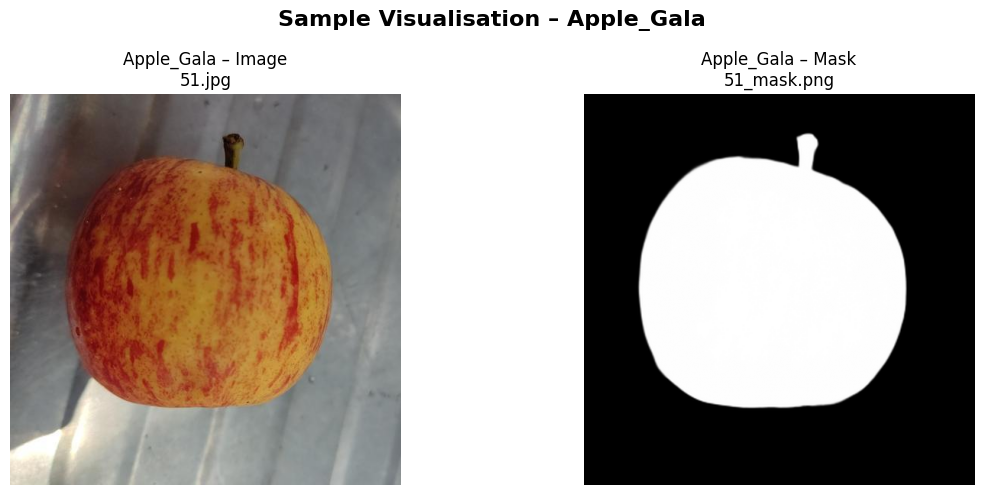


📊 RGB Histogram:
👉 Digunakan untuk melihat distribusi intensitas warna (R,G,B), memeriksa pencahayaan, warna dominan buah, dan mendeteksi gambar outlier.


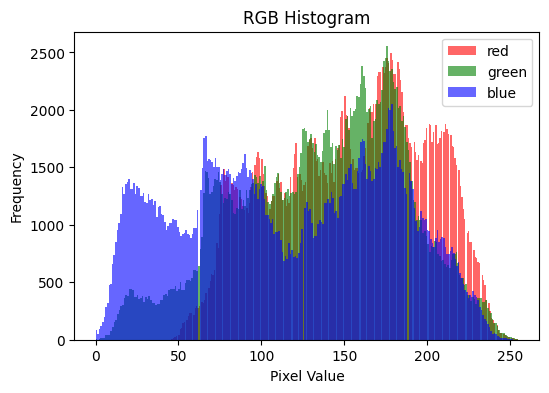


📊 Grayscale Histogram:
👉 Digunakan untuk melihat kontras keseluruhan, intensitas cahaya, dan kualitas brightness pada gambar.


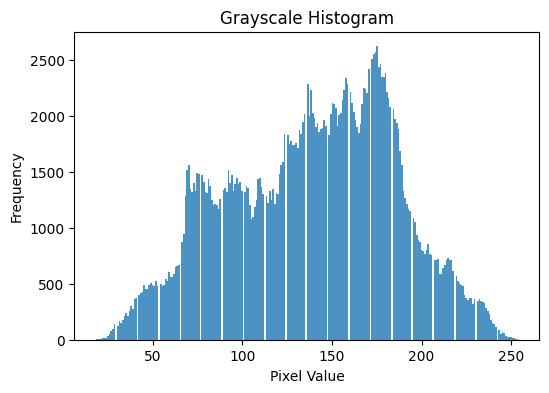


📊 Mask Histogram:
👉 Mask histogram digunakan untuk:
   - Memastikan mask bersifat biner (0 = background, 255 = objek).
   - Mengecek apakah ada nilai selain 0 dan 255 (mask rusak atau tidak bersih).
   - Mengukur seberapa besar area objek pada gambar dibanding background.
   - Mendeteksi mask kosong / salah pasangan.


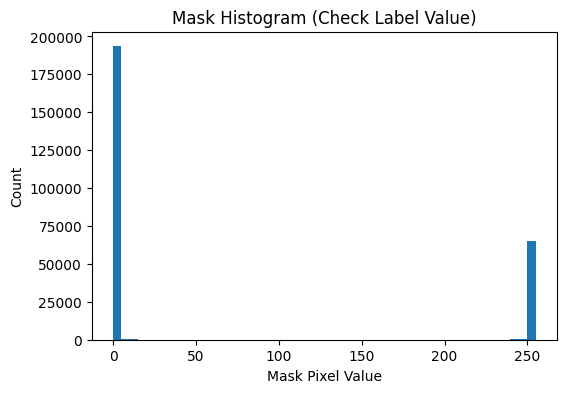

In [16]:
def visualize_all(fruit_dataset):
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    img_file = image_files[0]
    mask_file = mask_files[0]

    img = Image.open(os.path.join(images_path, img_file))
    mask = Image.open(os.path.join(masks_path, mask_file))

    print("📸 Menampilkan sample...")
    visualize_single_sample(fruit_dataset)

    print("\n📊 RGB Histogram:")
    print("👉 Digunakan untuk melihat distribusi intensitas warna (R,G,B), memeriksa pencahayaan, warna dominan buah, dan mendeteksi gambar outlier.")
    plot_rgb_histogram(img)

    print("\n📊 Grayscale Histogram:")
    print("👉 Digunakan untuk melihat kontras keseluruhan, intensitas cahaya, dan kualitas brightness pada gambar.")
    plot_grayscale_histogram(img)

    print("\n📊 Mask Histogram:")
    print("👉 Mask histogram digunakan untuk:")
    print("   - Memastikan mask bersifat biner (0 = background, 255 = objek).")
    print("   - Mengecek apakah ada nilai selain 0 dan 255 (mask rusak atau tidak bersih).")
    print("   - Mengukur seberapa besar area objek pada gambar dibanding background.")
    print("   - Mendeteksi mask kosong / salah pasangan.")
    plot_mask_histogram(mask)
    
visualize_all(datasets[0])


## Data Preparation

### Mapping Kelas (Nama Buah → Class ID)

In [21]:
# Membuat daftar nama buah
fruit_names = sorted([ds['fruit_name'] for ds in datasets])

# Mapping buah -> class ID
class_to_idx = {name: i+1 for i, name in enumerate(fruit_names)}  
# 0 = background, 1..30 = buah

print("Jumlah kelas:", len(class_to_idx))
class_to_idx


Jumlah kelas: 30


{'Apple_Gala': 1,
 'Apple_Golden Delicious': 2,
 'Avocado': 3,
 'Banana': 4,
 'Berry': 5,
 'Burmese Grape': 6,
 'Carambola': 7,
 'Date Palm': 8,
 'Dragon': 9,
 'Elephant Apple': 10,
 'Grape': 11,
 'Green Coconut': 12,
 'Guava': 13,
 'Hog Plum': 14,
 'Kiwi': 15,
 'Lichi': 16,
 'Malta': 17,
 'Mango Golden Queen': 18,
 'Mango_Alphonso': 19,
 'Mango_Amrapali': 20,
 'Mango_Bari': 21,
 'Mango_Himsagar': 22,
 'Olive': 23,
 'Orange': 24,
 'Palm': 25,
 'Persimmon': 26,
 'Pineapple': 27,
 'Pomegranate': 28,
 'Watermelon': 29,
 'White Pear': 30}

### Data Preparation

FRUITSEG30 DATA PREPARATION

[1] Validating dataset pairs...
OK Apple_Gala: 65 pairs valid
OK Apple_Golden Delicious: 57 pairs valid
OK Avocado: 72 pairs valid
OK Banana: 82 pairs valid
OK Berry: 62 pairs valid
OK Burmese Grape: 78 pairs valid
OK Carambola: 100 pairs valid
OK Date Palm: 147 pairs valid
OK Dragon: 96 pairs valid
OK Elephant Apple: 81 pairs valid
OK Grape: 82 pairs valid
OK Green Coconut: 37 pairs valid
OK Guava: 55 pairs valid
OK Hog Plum: 91 pairs valid
OK Kiwi: 61 pairs valid
OK Lichi: 48 pairs valid
OK Malta: 50 pairs valid
OK Mango Golden Queen: 16 pairs valid
OK Mango_Alphonso: 45 pairs valid
OK Mango_Amrapali: 67 pairs valid
OK Mango_Bari: 57 pairs valid
OK Mango_Himsagar: 85 pairs valid
OK Olive: 51 pairs valid
OK Orange: 83 pairs valid
OK Palm: 59 pairs valid
OK Persimmon: 33 pairs valid
OK Pineapple: 65 pairs valid
OK Pomegranate: 61 pairs valid
OK Watermelon: 42 pairs valid
OK White Pear: 41 pairs valid

Total valid pairs: 1969

DATASET STATISTICS
Total sample

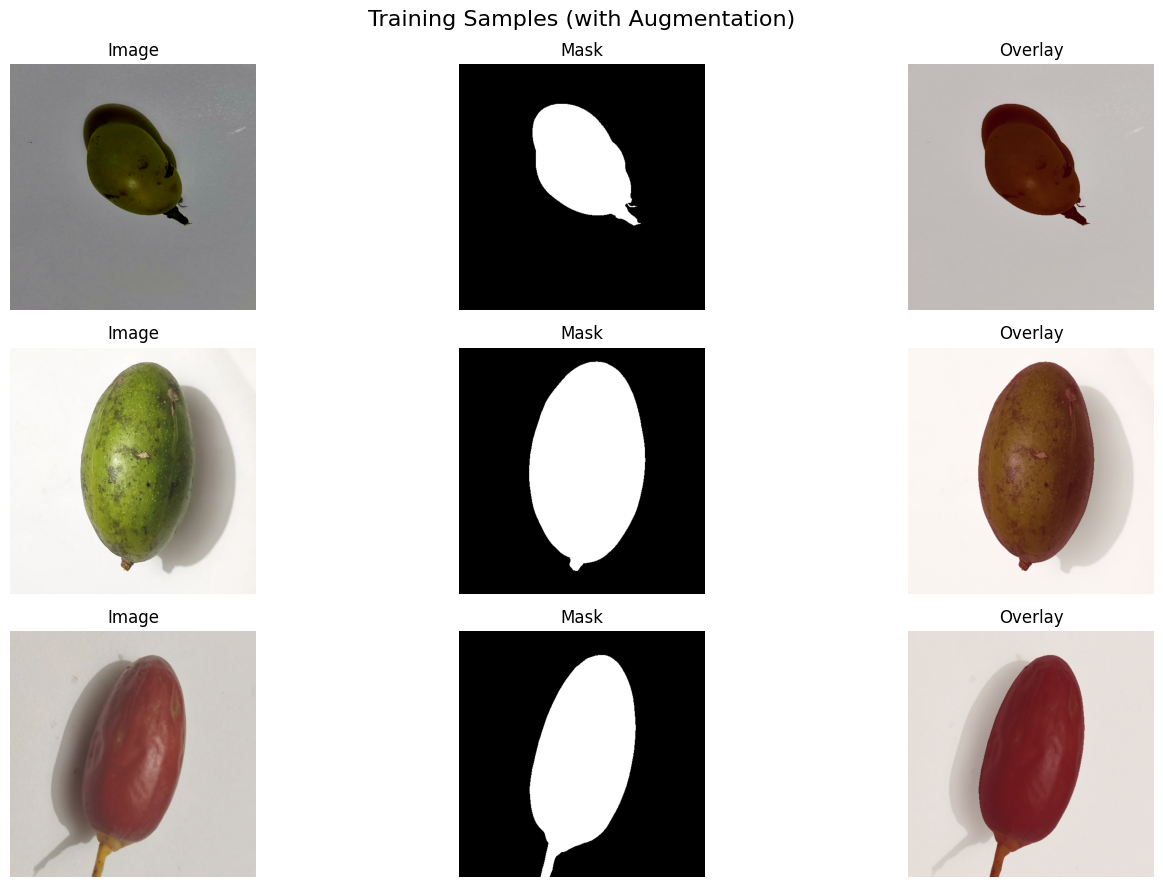

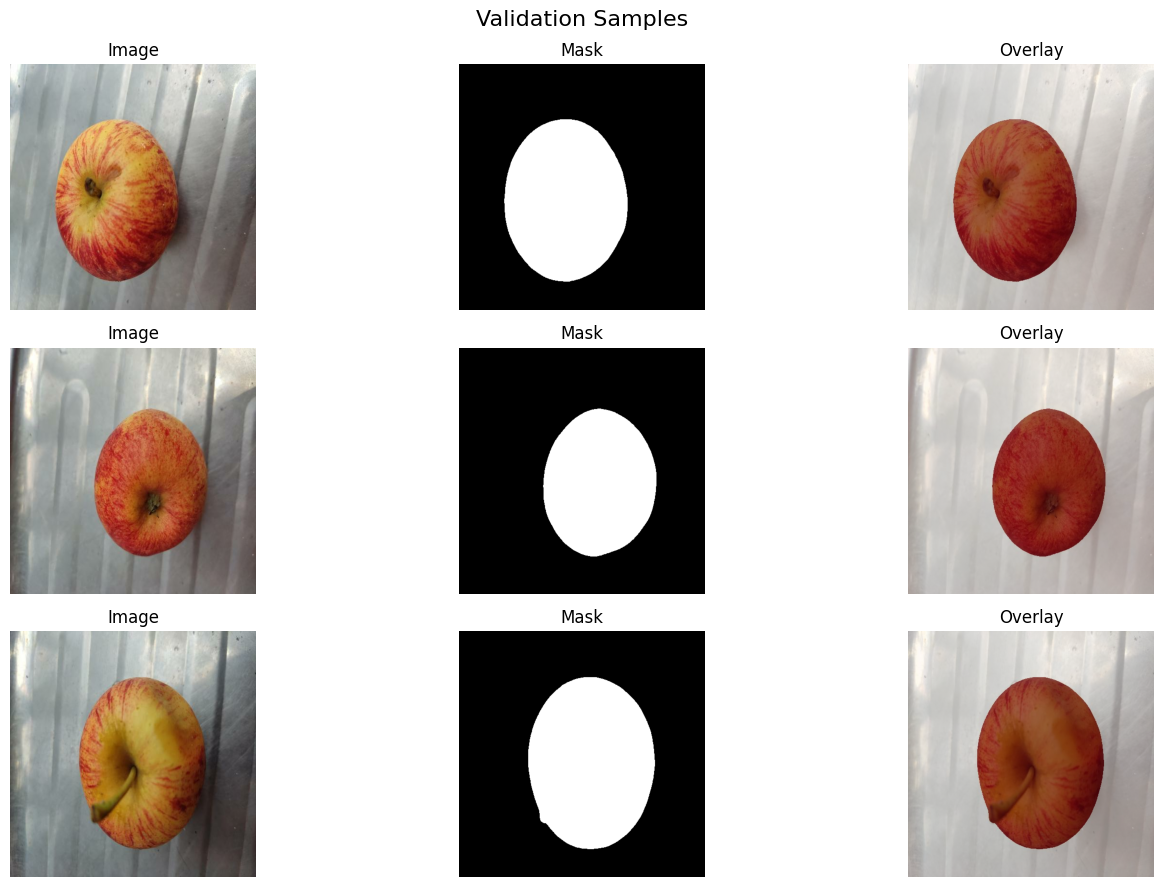


[5] Saving dataset information...

Dataset info saved to dataset_info/dataset_info.json

DATA PREPARATION COMPLETE!


In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import json


IMG_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 2  # Binary segmentation: background + fruit
SEED = 42

# Set random seeds untuk reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

def validate_dataset_pairs(datasets):
    """Validasi bahwa setiap gambar memiliki mask yang sesuai"""
    validated = []
    
    for ds in datasets:
        images_path = ds['images_path']
        masks_path = ds['masks_path']
        
        image_files = sorted([f for f in os.listdir(images_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        mask_files = sorted([f for f in os.listdir(masks_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        # Pastikan jumlah sama
        if len(image_files) != len(mask_files):
            print(f"WARNING {ds['fruit_name']}: Jumlah tidak sama (Images: {len(image_files)}, Masks: {len(mask_files)})")
            continue
        
        # Buat pairs
        pairs = []
        for img_file in image_files:
            # Coba berbagai format nama mask
            base_name = os.path.splitext(img_file)[0]
            possible_masks = [
                img_file,  # Nama sama persis
                f"{base_name}_mask.png",
                f"{base_name}.png",
                f"mask_{img_file}",
            ]
            
            mask_found = None
            for possible_mask in possible_masks:
                if possible_mask in mask_files:
                    mask_found = possible_mask
                    break
            
            if mask_found:
                pairs.append({
                    'image': os.path.join(images_path, img_file),
                    'mask': os.path.join(masks_path, mask_found),
                    'fruit': ds['fruit_name']
                })
        
        if pairs:
            validated.extend(pairs)
            print(f"OK {ds['fruit_name']}: {len(pairs)} pairs valid")
    
    return validated


def load_image(image_path):
    """Load dan preprocess gambar"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0  # Normalisasi [0, 1]
    return image

def load_mask(mask_path):
    """Load dan preprocess mask"""
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')
    
    # Convert ke binary (0 atau 1)
    mask = tf.cast(mask > 127, tf.float32)
    return mask

# DATA AUGMENTATION
@tf.function
def augment_train(image, mask):
    """Augmentasi untuk training set"""
    # Horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    # Vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    # Rotation (90, 180, 270 degrees)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)
    
    # Brightness adjustment (hanya untuk gambar)
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Clip values to [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, mask

@tf.function
def augment_val(image, mask):
    """Untuk validation/test - hanya normalisasi, tanpa augmentasi"""
    return image, mask

# ========================
# 4. DATASET PIPELINE
# ========================
def create_tf_dataset(image_paths, mask_paths, is_training=True, augment=True):
    """Buat TensorFlow dataset dengan pipeline optimal"""
    
    def load_data(image_path, mask_path):
        image = load_image(image_path)
        mask = load_mask(mask_path)
        return image, mask
    
    # Create dataset dari paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    # Shuffle untuk training
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000, seed=SEED)
    
    # Load images dan masks
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Augmentation
    if augment and is_training:
        dataset = dataset.map(augment_train, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(augment_val, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch dan prefetch
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# DATA SPLITTING
def split_dataset(pairs, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Split dataset menjadi train, val, test dengan stratifikasi per fruit"""
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratio harus total 1.0"
    
    # Group by fruit untuk stratified split
    from collections import defaultdict
    fruit_groups = defaultdict(list)
    for pair in pairs:
        fruit_groups[pair['fruit']].append(pair)
    
    train_pairs, val_pairs, test_pairs = [], [], []
    
    for fruit, fruit_pairs in fruit_groups.items():
        n = len(fruit_pairs)
        
        # Split train vs (val + test)
        train_p, temp_p = train_test_split(
            fruit_pairs, 
            test_size=(val_ratio + test_ratio),
            random_state=SEED
        )
        
        # Split val vs test
        relative_test_ratio = test_ratio / (val_ratio + test_ratio)
        val_p, test_p = train_test_split(
            temp_p,
            test_size=relative_test_ratio,
            random_state=SEED
        )
        
        train_pairs.extend(train_p)
        val_pairs.extend(val_p)
        test_pairs.extend(test_p)
        
        print(f"  {fruit}: Train={len(train_p)}, Val={len(val_p)}, Test={len(test_p)}")
    
    return train_pairs, val_pairs, test_pairs


def visualize_samples(dataset, num_samples=3, title="Samples"):
    """Visualisasi beberapa sample dari dataset"""
    plt.figure(figsize=(15, num_samples * 3))
    
    for images, masks in dataset.take(1):
        for i in range(min(num_samples, images.shape[0])):
            # Gambar asli (original fruit image)
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(images[i])
            plt.title("Image")
            plt.axis('off')
            
            # Mask (ground truth segmentation - area buah berwarna putih, background hitam)
            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(masks[i], cmap='gray')
            plt.title("Mask")
            plt.axis('off')
            
            # Overlay (gambar asli dengan mask di atasnya untuk melihat akurasi segmentasi)
            # Mask ditampilkan dengan warna merah semi-transparan (alpha=0.5) di atas gambar
            # Ini membantu visualisasi area mana yang akan di-segment oleh model
            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(images[i])
            plt.imshow(masks[i], cmap='Reds', alpha=0.5)
            plt.title("Overlay")
            plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
    plt.show()


# DATASET STATISTICS
def compute_dataset_stats(pairs):
    """Hitung statistik dataset"""
    from collections import Counter
    
    fruit_counts = Counter([p['fruit'] for p in pairs])
    
    print("\n" + "="*50)
    print("DATASET STATISTICS")
    print("="*50)
    print(f"Total samples: {len(pairs)}")
    print(f"\nDistribusi per fruit:")
    for fruit, count in sorted(fruit_counts.items()):
        print(f"  {fruit}: {count} ({count/len(pairs)*100:.1f}%)")
    
    return fruit_counts


# SAVE DATASET INFO
def save_dataset_info(train_pairs, val_pairs, test_pairs, save_dir='dataset_info'):
    """Simpan informasi dataset untuk reproducibility"""
    os.makedirs(save_dir, exist_ok=True)
    
    info = {
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'num_classes': NUM_CLASSES,
        'seed': SEED,
        'train_count': len(train_pairs),
        'val_count': len(val_pairs),
        'test_count': len(test_pairs),
        'train_files': [{'image': p['image'], 'mask': p['mask'], 'fruit': p['fruit']} for p in train_pairs],
        'val_files': [{'image': p['image'], 'mask': p['mask'], 'fruit': p['fruit']} for p in val_pairs],
        'test_files': [{'image': p['image'], 'mask': p['mask'], 'fruit': p['fruit']} for p in test_pairs],
    }
    
    with open(os.path.join(save_dir, 'dataset_info.json'), 'w') as f:
        json.dump(info, f, indent=2)
    
    print(f"\nDataset info saved to {save_dir}/dataset_info.json")

# ========================
print("FRUITSEG30 DATA PREPARATION")
print("="*60)

# 1. Validasi dataset pairs
print("\n[1] Validating dataset pairs...")
validated_pairs = validate_dataset_pairs(datasets)
print(f"\nTotal valid pairs: {len(validated_pairs)}")

# 2. Compute statistics
compute_dataset_stats(validated_pairs)

# 3. Split dataset
print("\n[2] Splitting dataset (70% train, 20% val, 10% test)...")
train_pairs, val_pairs, test_pairs = split_dataset(validated_pairs)

print(f"\nSplit summary:")
print(f"  Train: {len(train_pairs)} samples")
print(f"  Val:   {len(val_pairs)} samples")
print(f"  Test:  {len(test_pairs)} samples")

# 4. Create TF datasets
print("\n[3] Creating TensorFlow datasets...")

train_dataset = create_tf_dataset(
    [p['image'] for p in train_pairs],
    [p['mask'] for p in train_pairs],
    is_training=True,
    augment=True
)

val_dataset = create_tf_dataset(
    [p['image'] for p in val_pairs],
    [p['mask'] for p in val_pairs],
    is_training=False,
    augment=False
)

test_dataset = create_tf_dataset(
    [p['image'] for p in test_pairs],
    [p['mask'] for p in test_pairs],
    is_training=False,
    augment=False
)

print("Datasets created successfully!")

# 5. Visualize samples
print("\n[4] Visualizing samples...")
visualize_samples(train_dataset, num_samples=3, title="Training Samples (with Augmentation)")
visualize_samples(val_dataset, num_samples=3, title="Validation Samples")

# 6. Save dataset info
print("\n[5] Saving dataset information...")
save_dataset_info(train_pairs, val_pairs, test_pairs)

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE!")
print("="*60)